Бурамбекова Аружан, 412 группа.
Метод проекции градиента.

### Задача выпуклой оптимизации

Найти минимум функции на множестве: $\min\limits_{x \in X}f(x)$, где $f(x)$ - выпуклая функция, $X \subseteq \mathbb{R}^n$ - выпуклое множество
### Множество:  $X\in\mathbb{R}^n$, $n\in\{100, 200, 500, 1000\}$
1. $X$ симплекс
2. $X$ сфера
### Функция:     $f(x) = x^TAx - b^Tx$

$А$ — случайная [0,L] матрица, в которой элементы равномерно распределены, и она регуляризована как $A - \lambda_{\min}(A)I$, где $I$ — единичная матрица.

## Библиотеки

In [1]:
import numpy as np
from numpy import linalg
%matplotlib inline
import matplotlib.pyplot as plt
from prettytable import PrettyTable

$$A=S^TDS$$
S получается ортогонализацией Грамма-Шмидта из случайной матрицы, D задается явно ниже


In [2]:
# Размерность пространства
n=500
# Случайная матрица
S0=np.random.randn(n,n)

# Ортогонализация Грамма-Шмидта
S=np.copy(S0)
for i in range(n):
    S[i] = np.copy(S0[i])
    for j in range(i):
        S[i] -= S[j] * np.dot(S[i], S[j]) / np.dot(S[j], S[j])
    S[i] /= np.sqrt(np.dot(S[i], S[i]))

# Проверяем ортогональность
np.allclose(np.dot(S.T,S), np.eye(n))

True

In [3]:
# Собственные числа матрицы A
D=np.diag(np.linspace(1, 50, num = n))
A=np.dot(S.T, np.dot(D, S))
# Вектор b
b=np.random.rand(n)

### Функция: $f(x)=\frac{1}{2}x^TAx-b^Tx$

In [4]:
# Градиент функции
def grad(x):
    return(np.dot(A, x) - b)

In [5]:
# Функция
def func(x):
    return(0.5 * np.dot(x.T, np.dot(A, x))-np.dot(b, x))

### Проекция на S:     $S=B^{||\cdot||_2}_1(0)$

In [6]:
def p(x):
    norm = linalg.norm(x)
    if norm <= 1:
        return(x)
    else:
        return(x / norm)
def dist(x):
    return(linalg.norm(x - p(x)))

### Графики 

In [7]:
def pgd(x):
    y = np.zeros((len(x)))
    x_dist = np.zeros((len(x)))
    step = np.zeros((len(x)))
    table = PrettyTable()
    table.field_names = ['i', 'a', 'x[i]', 'func(x[i])', 'dist(x[i])']

    for i in range(len(x)):
        y[i] = func(x[i])
        x_dist[i] = linalg.norm(x[i]-p(x[i]))
        
        if i >= 1:
            step[i] = linalg.norm(x[i] - x[i - 1])
        
        if i == 1 or i == len(x)-1:
            table.add_row([i, step[i], x[i],  y[i],  x_dist[i]]) 
        
    imin = np.argmin(y)
    y -= func(x[imin])
    
    x_diff_norm = linalg.norm(x[:]-x[imin], axis=1)

    ms = 3
    
    print("Best: " + str(imin) + " f = " + str(func(x[imin])))
    print ("Last: " + str(len(x)))
    
    plt.figure(figsize=(10,10))
    plt.subplot(3, 1, 1)
    plt.plot(x_diff_norm, 'g.', label=r"$||x_i-x_{best}||$", ms=ms)
    plt.legend(loc='upper right', fontsize=18)
    plt.ylabel('Скорость сходимости', fontsize=10)
    
    plt.subplot(3, 1, 2)
    plt.plot(step, 'b.', label=r"$||x_i-x_{i-1}||$", ms=ms)
    plt.legend(loc='upper right', fontsize=18)
    plt.ylabel('Скорость сходимости', fontsize=10)
    
    plt.subplot(3, 1, 3)
    plt.plot(y, 'r.', label=r"$f(x_i)-f(x_{best})$", ms=ms)
    plt.legend(loc='upper right', fontsize=18)
    plt.xlabel('Количество итераций, $i$', fontsize=25)
    plt.ylabel('Скорость сходимости', fontsize=10)
    
    plt.show()

    print(table)

### Правило Армихо(Требование достаточного убывания)
Поиск шага по x, $\alpha_0$, $\theta$, $\varepsilon$.

Требование достаточного убывания гарантирует, что функция в точке $ f(x_k + \alpha s_k)$
 не превосходит линейной аппроксимации с коэффициентом наклона $\varepsilon$. Обычно коэффициент наклона выбирают в таких пределах: $\varepsilon \in (0, 0.3)$


Задаем $0<\varepsilon<1$, $0<\theta<1$.

Шаг 1. Проверяем, достаточно ли быстро уменьшается значение функции:
        $$ f(x_k + \alpha s_k) \leq f(x_k) + \varepsilon\alpha<\nabla f(x_k), s_k> $$

Шаг 2. Если нет - уменьшаем $\alpha_k = \theta\alpha$,
        если да, заканчиваем,   $\alpha_k = \alpha$

In [8]:
def step(x, a0, theta, eps):
    a = a0
    grad_norm_2 = np.linalg.norm(grad(x)) ** 2
    while True:
        x_new = x - a * grad(x)
        if func(x_new) - func(x) + eps * a * grad_norm_2 < 0:
            break
        a *= theta
    return a

## Метод проекции градиента
Идея метода проекции градиента состоит в том, что если на некоторой итерации точка оказывается вне множества допустимых значений, то она возвращается на это множество. 
$$t_{k+1}=\pi_{X}(x_k-\alpha_k\nabla f(x_k))$$
$$x_{k+1}=(1-v)x_k+vt_{k+1}$$
Шаг $\alpha_k$ на каждой итерации будем выбирать по требованию достаточного убывания.

In [9]:
# Массив с точками
x = list()
x.append(np.zeros(n))
i = 1

# Выбор шага по Армихо, параметры
a0 = 1
theta = 0.1
eps = 0.1

# Условия остановки
grad_norm=1e-7
maxiter=300
x_norm=1e-6

v = 0.4

while True:
    x.append(0)
    
    a = step(x[i - 1], a0, theta, eps)
    # Градиентный шаг
    x[i] = x[i - 1] - a * grad(x[i - 1])
    
    #Проектирование
    proj = np.copy(p(x[i]))
    x[i] = (1 - v) * x[i - 1] + v * proj
    vector = np.vectorize(np.float64)
    x[i] = vector(x[i])
    
    norm_new = np.linalg.norm(grad(x[i]))
   
    
    # Условия останова
    if norm_new < grad_norm:
        break
    
    if np.linalg.norm(proj - x[i - 1]) < x_norm:
        break
    
    if i >= maxiter:
        break
    
    i += 1

Best: 93 f = -5.597192002705201
Last: 94


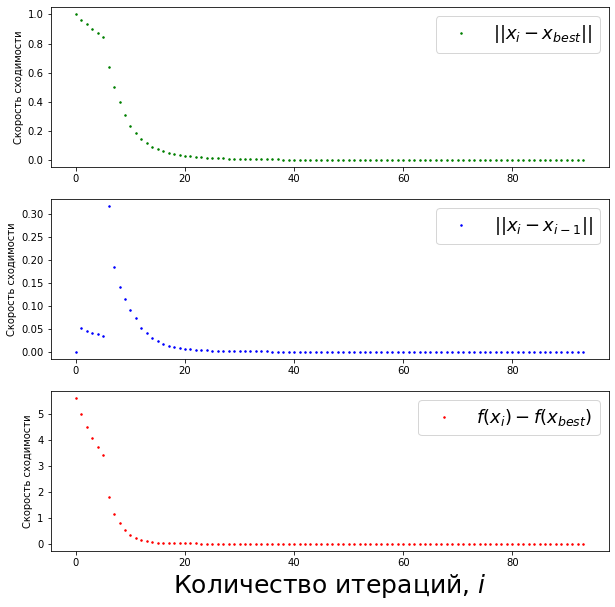

+----+------------------------+-------------------------------------------------------------------+---------------------+------------+
| i  |           a            |                                x[i]                               |      func(x[i])     | dist(x[i]) |
+----+------------------------+-------------------------------------------------------------------+---------------------+------------+
| 1  |  0.05125082202473527   |    [5.89671634e-04 3.41688624e-03 3.19239910e-04 1.58623413e-03   | -0.6224047106099924 |    0.0     |
|    |                        |     2.20694526e-03 3.70188636e-03 1.02731081e-04 1.74915717e-03   |                     |            |
|    |                        |     1.76630568e-03 2.65669902e-03 1.61365224e-03 3.96378673e-03   |                     |            |
|    |                        |     3.44261540e-03 1.57036326e-03 3.37624128e-03 8.61579362e-04   |                     |            |
|    |                        |     8.91554397e-04 1.48

In [10]:
pgd(x)